In [1]:
#conda install -c conda-forge pyarrow

In [2]:
# conda install -c conda-forge lightgbm
# conda install -c conda-forge xgboost

# Librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
from multiprocessing import Pool
import os
cpuCount = os.cpu_count()
cpuCount

12

In [5]:
db = pd.read_parquet('db_P4.parquet.gzip')
#Energy_Star_Score = db[['OSEBuildingID','ENERGYSTARScore']]
db = db.drop(columns=['log_TotalGHGEmissions']) # On supprime la cible 1 pour éviter toute confusion
db

,OSEBuildingID,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,per_gfa_parking,per_gfa_bulding,site_per_electricity,site_per_steam,...,Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Restaurant,Retail Store,Self-Storage Facility,Social/Meeting Hall,Supermarket/Grocery Store,Swimming Pool,Worship Facility
0,1,47.61220,-122.33799,1927,1.0,12,0.000000,1.000000,0.546060,0.277302,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,47.61317,-122.33393,1996,1.0,11,0.145453,0.854547,0.386609,0.000000,...,0.000000,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,3,47.61393,-122.33810,1969,1.0,41,0.205748,0.794252,0.682307,0.297113,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,5,47.61412,-122.33664,1926,1.0,10,0.000000,1.000000,0.407519,0.325913,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,8,47.61375,-122.34047,1980,1.0,18,0.353115,0.646885,0.378802,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,50221,47.54067,-122.37441,1982,1.0,1,0.000000,1.000000,0.678440,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1479,50223,47.59625,-122.32283,2004,1.0,1,0.000000,1.000000,0.417296,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1480,50224,47.63644,-122.35784,1974,1.0,1,0.000000,1.000000,0.310820,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1481,50225,47.52832,-122.32431,1989,1.0,1,0.000000,1.000000,0.484898,0.000000,...,0.034324,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Energy_Star_Score # On le conserve pour le tester sur notre modèle final

# Variables prédictives X & Cible y 

In [7]:
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import explained_variance_score,mean_absolute_error, r2_score,  mean_squared_error

from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import xgboost as xgb

import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

from time import time


In [8]:
features_names = db.drop(columns=['log_SiteEnergyUseWN(kBtu)','OSEBuildingID','ENERGYSTARScore']).copy().columns
features_names = list(features_names)
print('Nombre de features : ',len(features_names))

Nombre de features :  40


In [9]:
X = db.drop(columns=['log_SiteEnergyUseWN(kBtu)','OSEBuildingID','ENERGYSTARScore']).copy()
X = X.fillna(0)
X.isna().mean()

Latitude                                           0.0
Longitude                                          0.0
YearBuilt                                          0.0
NumberofBuildings                                  0.0
NumberofFloors                                     0.0
per_gfa_parking                                    0.0
per_gfa_bulding                                    0.0
site_per_electricity                               0.0
site_per_steam                                     0.0
site_per_gaz                                       0.0
Bank Branch                                        0.0
College/University                                 0.0
Data Center                                        0.0
Distribution Center                                0.0
Fitness Center/Health Club/Gym                     0.0
Food Service                                       0.0
Hospital (General Medical & Surgical)              0.0
Hotel                                              0.0
K-12 Schoo

In [10]:
#X = db.drop(columns=['log_TotalGHGEmissions','OSEBuildingID','ENERGYSTARScore']).copy()
X = np.array(X)
print('Nb de lignes X : ',X.shape[0],'\n','Nb de features X : ',X.shape[1])

Nb de lignes X :  1483 
 Nb de features X :  40


In [11]:
y = db['log_SiteEnergyUseWN(kBtu)'].copy()
y = np.array(y)
print('Nb de lignes y à prédire : ',y.shape[0])

Nb de lignes y à prédire :  1483


# Train & Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 2023)

# Modèle 

In [13]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror' ,n_jobs= -1)
lg = lgb.LGBMRegressor(n_jobs=-1)
Svr = SVR(C=.05, epsilon=0.2)

regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    xg_reg,
    lg,
    SGDRegressor(),
    Svr
    
    
]

In [14]:
#head = 11
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.000s
	Prediction time: 0.014s
	Explained variance: 0.41516710008786883
	Mean absolute error: 0.7733463489918986
	R2 score: 0.3984820981652477

GradientBoostingRegressor()
	Training time: 0.213s
	Prediction time: 0.000s
	Explained variance: 0.5464805381937803
	Mean absolute error: 0.6780120799612254
	R2 score: 0.543455244894059

KNeighborsRegressor()
	Training time: 0.000s
	Prediction time: 0.000s
	Explained variance: 0.41516710008786883
	Mean absolute error: 0.7733463489918986
	R2 score: 0.3984820981652477

ExtraTreesRegressor()
	Training time: 0.405s
	Prediction time: 0.016s
	Explained variance: 0.5550256590083311
	Mean absolute error: 0.6670708122861785
	R2 score: 0.5484963965468324

RandomForestRegressor()
	Training time: 0.580s
	Prediction time: 0.018s
	Explained variance: 0.5332134123095407
	Mean absolute error: 0.6788561469931215
	R2 score: 0.5285822186726186

DecisionTreeRegressor()
	Training time: 0.010s
	Prediction time: 0.000s
	Explaine

# Fonction ML avec cross validation 
    Comparer les modèles

In [15]:
# Fonction 

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def ML (model, X = X_train, y = y_train, param = None):
    
    seed = 7
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)

    if param is not None:
        
        gs = GridSearchCV(model, param_grid = param, cv = kfold, scoring = 'r2').fit(X,y)
        print(gs.best_params_)
        model.set_params(**gs.best_params_)
    
    list_pred = []
    list_val = []

    start = time()
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed).split(X_train)
    
    for train, test in kfold:
        list_pred.append(model.fit(X[train],y[train]).predict(X[test]))
        list_val.append(y[test])
        
    end = time()
    
    list_pred = np.concatenate(list_pred)
    list_val = np.concatenate(list_val)


    print('\n',model,
                 '\n MSE : ', mean_squared_error(list_pred,list_val),
                 '\n R2 : ', r2_score(list_pred,list_val),
                 '\n Prédictions : ' , list_pred[:10], 
                 '\n Valeurs : ' , list_val[:10],
                 '\n Time' , end-start) 
    
    result = {'model' : model,
            'MSE' : mean_squared_error(list_pred,list_val),
            'R2' : r2_score(list_pred,list_val),
            'Prédictions' : list_pred,
            'Valeurs' : list_val,
            'Time' : end-start
             }
    
    if param is not None : 
        result['Best Params'] = gs.best_params_ 

    return result
                

###  Test 

In [16]:
test = ML(LinearRegression()) #OK !


 LinearRegression() 
 MSE :  0.9494422741670543 
 R2 :  -0.0903730521171231 
 Prédictions :  [14.6516051  15.28661359 14.8873325  14.77345322 14.68583946 15.52024577
 14.37918563 14.54190667 14.47727704 14.33089168] 
 Valeurs :  [15.35792826 15.973282   14.39313374 15.2669369  16.13712582 14.96455349
 13.84649959 14.49818522 13.62930145 13.68646431] 
 Time 0.00792551040649414


In [17]:
#test

In [17]:
for model in regressors:
    ML(model)


 KNeighborsRegressor() 
 MSE :  1.1200991334994477 
 R2 :  -0.6456095540144255 
 Prédictions :  [15.31527097 15.76805132 14.74025129 15.161718   15.32638259 15.26492036
 14.71454381 14.11606711 14.81350487 13.229659  ] 
 Valeurs :  [15.35792826 15.973282   14.39313374 15.2669369  16.13712582 14.96455349
 13.84649959 14.49818522 13.62930145 13.68646431] 
 Time 0.022775650024414062

 GradientBoostingRegressor() 
 MSE :  0.699265547080229 
 R2 :  0.08279242447734858 
 Prédictions :  [15.86778533 15.2665809  14.66202519 15.45317204 15.74104365 15.67208799
 14.56562805 14.94548387 14.10499496 14.01144372] 
 Valeurs :  [15.35792826 15.973282   14.39313374 15.2669369  16.13712582 14.96455349
 13.84649959 14.49818522 13.62930145 13.68646431] 
 Time 0.7688586711883545

 KNeighborsRegressor() 
 MSE :  1.1200991334994477 
 R2 :  -0.6456095540144255 
 Prédictions :  [15.31527097 15.76805132 14.74025129 15.161718   15.32638259 15.26492036
 14.71454381 14.11606711 14.81350487 13.229659  ] 
 Valeurs

### Hyper Paramètres avec fonction Zip

In [18]:
model_list = [LinearRegression(),
              RandomForestRegressor(n_jobs= -1), # Parallélisation tous les CPU -1 
              xgb.XGBRegressor(n_jobs= -1 ),
              lgb.LGBMRegressor(n_jobs= -1)
             ]

params_list =  [None, # LinearRegressioin pas d'hyper paramètre
                {'n_estimators' : [80, 100, 120] , # RF
                 'max_depth': [5, 10, 20, 25],
                 'min_samples_split': [2, 5, 8, 10],
                 'min_samples_leaf': [1, 2, 5]
                },
                { 'n_estimators' : [50,100,1000], # XGB
                 'max_depth' : [5, 10, 20],
                 'eta' : [0.01,0.1,0.5],
                 'subsample': [0.3,0.5,0.7],
                 'colsample_bytree' : [0.3,0.5,0.7]
                },
                {'n_estimators': [80, 100, 120, 150], # LGBM
                 'max_depth': [3, 5, 8, 10],
                 'num_leaves': [6, 8, 10]
                }
                
               
               ]



#zip_object = zip(model_list,params_list)


In [19]:
res = [] # On récupère les résultats des hyper paramètres dans l'objet res
for model,param in zip(model_list,params_list):
    res.append(ML(model=model,param=param))


 LinearRegression() 
 MSE :  0.9494422741670543 
 R2 :  -0.0903730521171231 
 Prédictions :  [14.6516051  15.28661359 14.8873325  14.77345322 14.68583946 15.52024577
 14.37918563 14.54190667 14.47727704 14.33089168] 
 Valeurs :  [15.35792826 15.973282   14.39313374 15.2669369  16.13712582 14.96455349
 13.84649959 14.49818522 13.62930145 13.68646431] 
 Time 0.007766246795654297
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

 RandomForestRegressor(max_depth=20, min_samples_split=10, n_jobs=-1) 
 MSE :  0.7368261625349561 
 R2 :  0.06795068020184147 
 Prédictions :  [15.57980993 15.62641189 15.02511242 15.39804976 15.93364747 15.43554496
 14.2344648  14.59671012 13.9113492  14.30005074] 
 Valeurs :  [15.35792826 15.973282   14.39313374 15.2669369  16.13712582 14.96455349
 13.84649959 14.49818522 13.62930145 13.68646431] 
 Time 0.5904297828674316
{'colsample_bytree': 0.7, 'eta': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}

 XGBReg

# PLot

## Meilleur modèle en fonction des métriques R2 et MSE

In [46]:
tmp = pd.DataFrame({'Algorithme' : ['Regression Linéaire','RandomForest','XGBOOST','LGBM'],
                    'R2' : [x['R2'] for x in res],
                    'MSE' : [x['MSE'] for x in res]
    
})
tmp

,Algorithme,R2,MSE
0,Regression Linéaire,-0.090373,0.949442
1,RandomForest,0.067951,0.736826
2,XGBOOST,0.234928,0.648892
3,LGBM,0.117898,0.737430


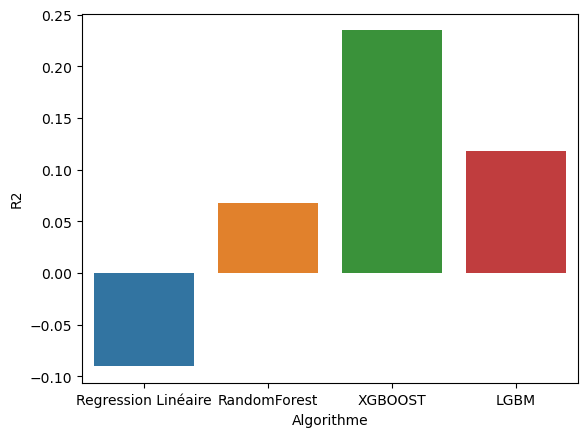

In [47]:
sns.barplot(data=tmp,x='Algorithme',y="R2")
plt.show()

In [48]:
tmp2 = pd.melt(tmp,id_vars='Algorithme')
tmp2

,Algorithme,variable,value
0,Regression Linéaire,R2,-0.090373
1,RandomForest,R2,0.067951
2,XGBOOST,R2,0.234928
3,LGBM,R2,0.117898
4,Regression Linéaire,MSE,0.949442
5,RandomForest,MSE,0.736826
6,XGBOOST,MSE,0.648892
7,LGBM,MSE,0.737430


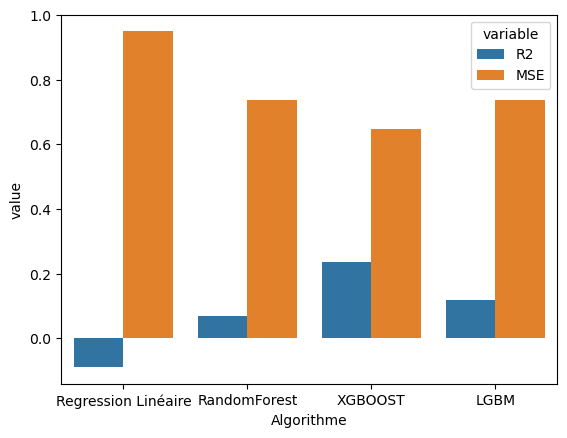

In [49]:
sns.barplot(data=tmp2, x='Algorithme',y='value',hue='variable')
plt.show()

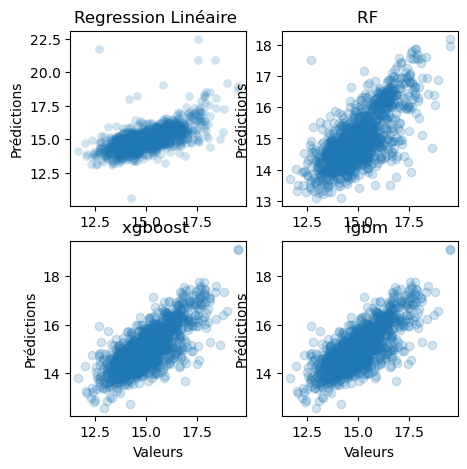

In [24]:
plt.figure(figsize=(5,5))

plt.subplot(2,2,1)

plt.scatter(res[0]['Valeurs'],res[0]['Prédictions'],alpha=0.2, linewidths = .1)
plt.title('Regression Linéaire ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,2)

plt.scatter(res[1]['Valeurs'],res[1]['Prédictions'],alpha=0.2)
plt.title('RF ')
plt.ylabel('Prédictions')
#plt.xlabel('Valeurs')

plt.subplot(2,2,3)

plt.scatter(res[2]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
plt.title('xgboost ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.subplot(2,2,4)

plt.scatter(res[3]['Valeurs'],res[2]['Prédictions'],alpha=0.2)
#plt.plot(res[3]['Valeurs'],res[2]['Prédictions'])
plt.title('lgbm ')
plt.ylabel('Prédictions')
plt.xlabel('Valeurs')

plt.show()



# Final XGB model

In [25]:
final_xgb =  xgb.XGBRegressor( max_depth=3, n_estimators=150,n_jobs= -1) 

In [26]:
final_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
pred_xgb = final_xgb.predict(X_test)

In [28]:
mean_squared_error(pred_xgb,y_test),r2_score(pred_xgb,y_test)

(0.7911553097245452, 0.22783230660289744)

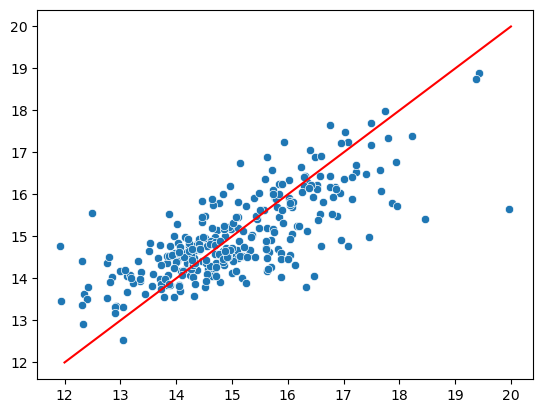

In [45]:
sns.scatterplot(x= y_test , y=pred_xgb)

X_plot = np.linspace(12, 20, 100)
Y_plot = X_plot

plt.plot(X_plot,Y_plot,color='r')
plt.show()

# SHAP 

In [32]:
#conda install -c conda-forge shap

In [30]:
import shap 

In [31]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [32]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

## Shap Features Importances

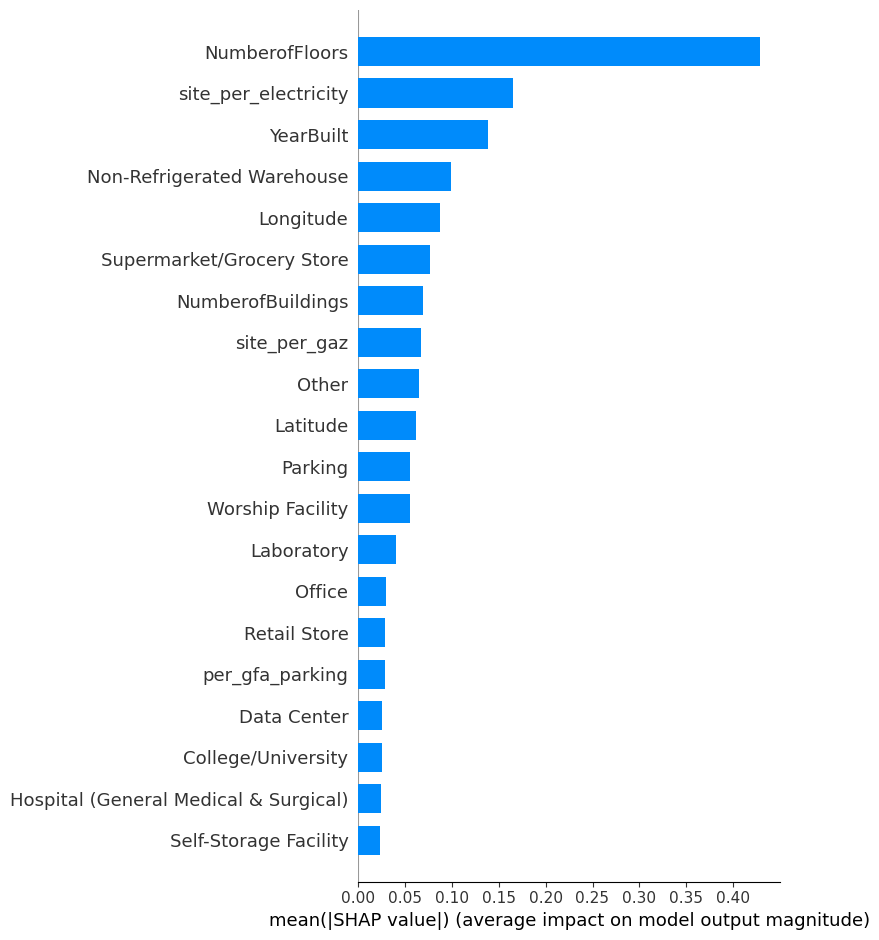

In [33]:
shap_values = shap.TreeExplainer(final_xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=features_names)

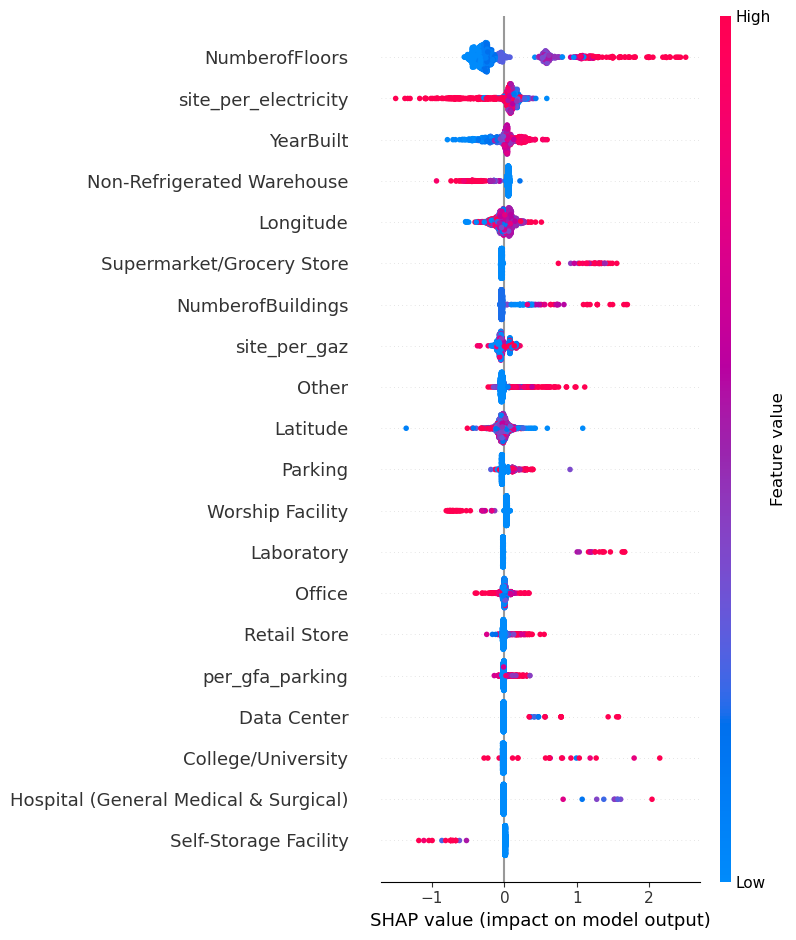

In [34]:
shap.summary_plot(shap_values, X_train,feature_names=features_names)

# Prédiction uniquement avec une adresse postale ? 
    Scénario OpenClassrooms : Question de Douglas : Peut-on déduire des choses intérressantes d'une simple adresse ?
    - Prenons notre modèle final_xgb
    - entrainnons le sur X : var = Latitude et Longitude

In [36]:
db

,OSEBuildingID,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,per_gfa_parking,per_gfa_bulding,site_per_electricity,site_per_steam,...,Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Restaurant,Retail Store,Self-Storage Facility,Social/Meeting Hall,Supermarket/Grocery Store,Swimming Pool,Worship Facility
0,1,47.61220,-122.33799,1927,1.0,12,0.000000,1.000000,0.546060,0.277302,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,47.61317,-122.33393,1996,1.0,11,0.145453,0.854547,0.386609,0.000000,...,0.000000,0.0,0.0,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,3,47.61393,-122.33810,1969,1.0,41,0.205748,0.794252,0.682307,0.297113,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,5,47.61412,-122.33664,1926,1.0,10,0.000000,1.000000,0.407519,0.325913,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,8,47.61375,-122.34047,1980,1.0,18,0.353115,0.646885,0.378802,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,50221,47.54067,-122.37441,1982,1.0,1,0.000000,1.000000,0.678440,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1479,50223,47.59625,-122.32283,2004,1.0,1,0.000000,1.000000,0.417296,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1480,50224,47.63644,-122.35784,1974,1.0,1,0.000000,1.000000,0.310820,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1481,50225,47.52832,-122.32431,1989,1.0,1,0.000000,1.000000,0.484898,0.000000,...,0.034324,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
db[['Latitude','Longitude']]

,Latitude,Longitude
0,47.61220,-122.33799
1,47.61317,-122.33393
2,47.61393,-122.33810
3,47.61412,-122.33664
4,47.61375,-122.34047
...,...,...
1478,47.54067,-122.37441
1479,47.59625,-122.32283
1480,47.63644,-122.35784
1481,47.52832,-122.32431


In [38]:
# On conserve cette fois ci les variables/features Latitude et Longitude
# y demeure inchangé
X_simple_address = db[['Latitude','Longitude']].copy() 
X_simple_address = np.array(X_simple_address)
X_simple_address

array([[  47.6122 , -122.33799],
       [  47.61317, -122.33393],
       [  47.61393, -122.3381 ],
       ...,
       [  47.63644, -122.35784],
       [  47.52832, -122.32431],
       [  47.53939, -122.29536]])

In [39]:
X_train_address, X_test_address, y_train_address, y_test_address = train_test_split(X_simple_address, y, test_size=0.2 , random_state = 2023)

In [40]:
final_xgb.fit(X_train_address,y_train_address)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [41]:
pred_simple_address = final_xgb.predict(X_test_address)

In [42]:
print('MSE : ', mean_squared_error(pred_simple_address,y_test_address),'\n',
      'R2 : ',r2_score(pred_simple_address,y_test_address))

MSE :  1.7044333889865884 
 R2 :  -2.025505739990138


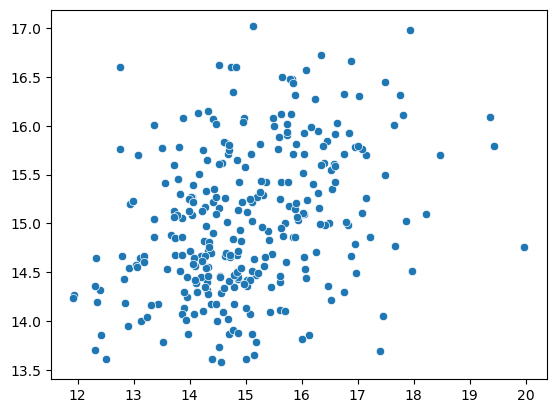

In [43]:
sns.scatterplot(x= y_test_address , y= pred_simple_address,lw=2)
plt.show()

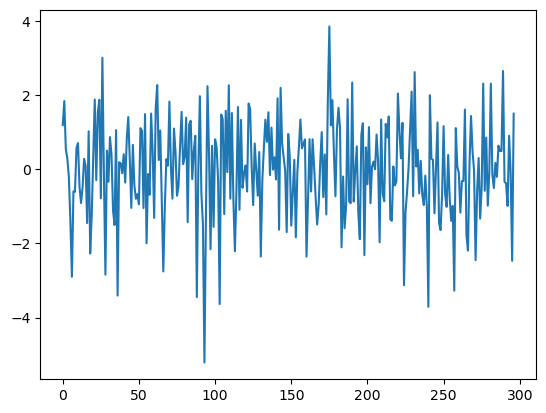

In [44]:
plt.plot(pred_simple_address-y_test_address)
plt.show()

Résultat peu convaincant 